<a href="https://colab.research.google.com/github/Dilagshan/Extracting-Informations-from-bills/blob/main/Extract_informations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment : Extracting informations from Bills**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [3]:
# Import the needed libraries
import pytesseract 
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import re

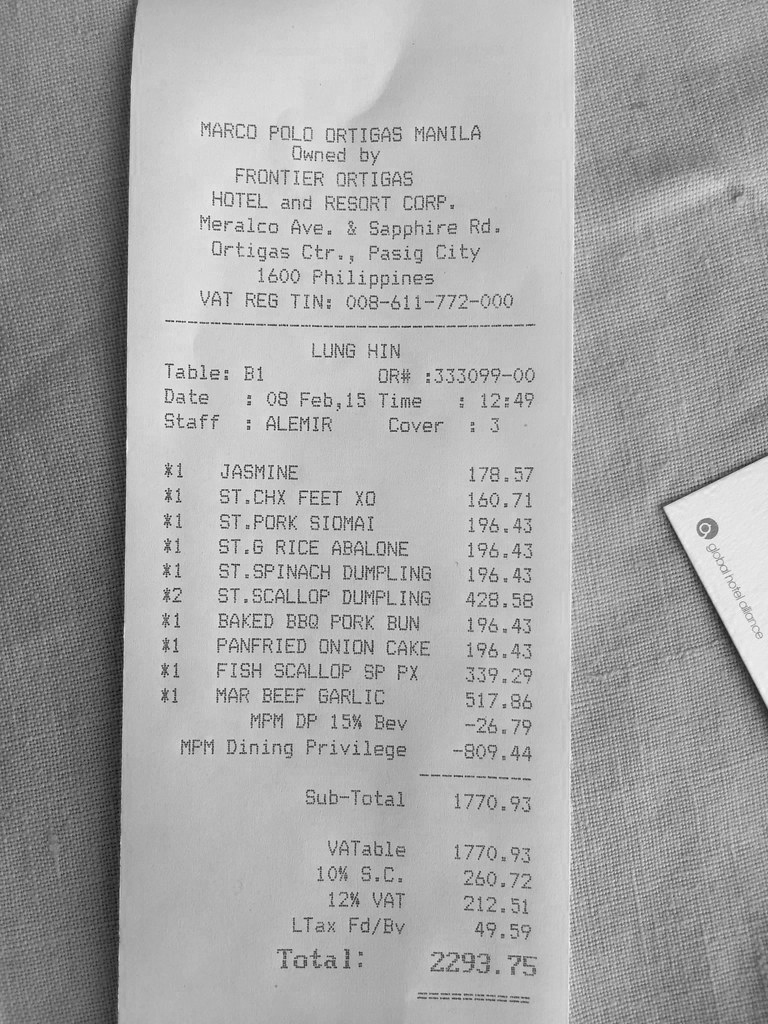

In [81]:
# read the images using open cv
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/Extract information on bills/bill.jpg')
cv2_imshow(img[:,:,0])

In [6]:
# Extract the informations using pytesseract module and do some preprocessing
extracted_text = pytesseract.image_to_string(img[:,:,0]) # Zero the blue plane for increasing accuracy
split_text = extracted_text.splitlines()  # Split the text by lines
for i in split_text:
  spaces = ['',' ','  ','   ','    ','     ']
  if i in spaces:
    split_text.remove(i)
split_text

['HOTEL and RESORT CORP.',
 'Meralco Ave. & Sapphire Rd.',
 'Ortigas Ctr., Pasig City',
 '  ',
 ' ',
 ' ',
 'LUNG HIN',
 'Table: Bi OR# :333099-00',
 'Date +: 08 Feb,iS Time +: 12:47',
 'Staff +: ALEMIR Cover : 3',
 '10 JASMINE 178.57',
 '41 ST.CHX FEET x0 140,71',
 '¥100-ST.PORK SIOMAT 196.43',
 'x10 ST.G RICE ABALONE 196.43',
 'X10 ST.SPINACH DUMPLING © 196.43',
 'x20 ST.SCALLOP DUMPLING 428.58',
 '1 BAKED BRQ PORK BUN 196.43',
 '1° PANFRIED ONION CAKE 194.43',
 '*¥1 FISH SCALLOP SP Px 339.29',
 '41) MAR BEEF GARLIC 517.86',
 'MPM DP 15% Bey T2607)',
 'MPM Dining Privilege 809.44',
 ' ',
 'Sub-Total 1770.93',
 'VATable 1770.93',
 '10% S.C. 260,72',
 '124% VAT 212.51',
 'LTax Fd/By 49,59',
 'Total: 2293.75',
 ' ',
 '',
 ' ',
 '']

In [30]:
# Extract the consumed items part separately
for sentences in split_text:
  if 'Cover' in sentences:
    start_index = split_text.index(sentences)
  elif 'MPM' in sentences:
    end_index = split_text.index(sentences)

items_list = split_text[start_index+1:end_index-1]
items_list

['10 JASMINE 178.57',
 '41 ST.CHX FEET x0 140,71',
 '¥100-ST.PORK SIOMAT 196.43',
 'x10 ST.G RICE ABALONE 196.43',
 'X10 ST.SPINACH DUMPLING © 196.43',
 'x20 ST.SCALLOP DUMPLING 428.58',
 '1 BAKED BRQ PORK BUN 196.43',
 '1° PANFRIED ONION CAKE 194.43',
 '*¥1 FISH SCALLOP SP Px 339.29',
 '41) MAR BEEF GARLIC 517.86']

In [8]:
# Extract the items list by using regular expressions
items = []
for sents in items_list:
  item = re.findall(r'\b[A-Z]\D[^0-9]*',sents)
  item =''.join(item)
  items.append(item.strip())
print(items)


['JASMINE', 'ST.CHX FEET x', 'ST.PORK SIOMAT', 'ST.G RICE ABALONE', 'ST.SPINACH DUMPLING ©', 'ST.SCALLOP DUMPLING', 'BAKED BRQ PORK BUN', 'PANFRIED ONION CAKE', 'FISH SCALLOP SP Px', 'MAR BEEF GARLIC']


In [9]:
# Extract the prices by using regular expressions
price_list = []
for sents in items_list:
  price = re.findall(r'[0-9]+\.[0-9]+',sents) 
  if price == []:
    price = re.findall(r'[0-9]+\,[0-9]+',sents)
  price_list.append(''.join(price))
print(price_list)

['178.57', '140,71', '196.43', '196.43', '196.43', '428.58', '196.43', '194.43', '339.29', '517.86']


In [10]:
# Make the consumed items dictionary
x = 0
consumed_items = []
for i in items:
  itemdict = {}
  itemdict["Item"] = i
  itemdict["Price"] = price_list[x]
  consumed_items.append(itemdict)
  x += 1

consumed_items

[{'Item': 'JASMINE', 'Price': '178.57'},
 {'Item': 'ST.CHX FEET x', 'Price': '140,71'},
 {'Item': 'ST.PORK SIOMAT', 'Price': '196.43'},
 {'Item': 'ST.G RICE ABALONE', 'Price': '196.43'},
 {'Item': 'ST.SPINACH DUMPLING ©', 'Price': '196.43'},
 {'Item': 'ST.SCALLOP DUMPLING', 'Price': '428.58'},
 {'Item': 'BAKED BRQ PORK BUN', 'Price': '196.43'},
 {'Item': 'PANFRIED ONION CAKE', 'Price': '194.43'},
 {'Item': 'FISH SCALLOP SP Px', 'Price': '339.29'},
 {'Item': 'MAR BEEF GARLIC', 'Price': '517.86'}]

**Using the Spacy library (NLP) for further extraction**

In [ ]:
!pip install spacy --upgrade

In [12]:
# Import the spacy library for NLP purposes
import spacy

In [ ]:
!python -m spacy download en_core_web_sm

In [14]:
# Load the English language
nlp = spacy.load('en_core_web_sm')

In [15]:
document = nlp(extracted_text) # Convert the extract text into the format of spacy

In [110]:
search_strings = ['Table', 'Staff','Cover','VATable','10% S.C.','124% VAT','LTax Fd/By','Total'] # Words that I want to find
tokens_list = [nlp(item) for item in search_strings] # Putting into the formats of spacy library

In [111]:
from spacy.matcher import PhraseMatcher # import phraseMatcher for searching purpose
matcher = PhraseMatcher(nlp.vocab) # Search for the key words
matcher.add('SEARCH', None, *tokens_list)

In [112]:
matches = matcher(document) # find the id and positions of search strings in document
matches

[(8661325627334373315, 25, 26),
 (8661325627334373315, 47, 48),
 (8661325627334373315, 51, 52),
 (8661325627334373315, 134, 135),
 (8661325627334373315, 137, 138),
 (8661325627334373315, 140, 143),
 (8661325627334373315, 145, 148),
 (8661325627334373315, 150, 154),
 (8661325627334373315, 156, 157)]

In [146]:
for x in range(9):
  if x == 0: # Indicates the Table
    Table = document[matches[x][1]+2:matches[x][2]+2]
  
  elif x == 1: # Indicates the Staff
    Staff = document[matches[x][1]+3:matches[x][2]+3]
    
  elif x == 2: # Indicates the Cover
    Cover = document[matches[x][1]+2:matches[x][2]+2]
       
  elif x == 3:  # Indicates the sub-total
    Sub_total = document[matches[x][1]+1:matches[x][2]+1]

  elif x == 4: # Indicates the VATable
    VATable = document[matches[x][1]+1:matches[x][2]+1]  

  elif x == 5: # Indicates the 10% S.C.
    SC = document[matches[x][1]+3:matches[x][2]+1]  

  elif x == 6: # Indicates the 124% VAT
    VAT = document[matches[x][1]+3:matches[x][2]+1]  

  elif x == 7: # Indicates the LTax Fd/By
    LTax = document[matches[x][1]+4:matches[x][2]+1]  

  elif x == 8: # Indicates the Total
    Total = document[matches[x][1]+2:matches[x][2]+2]

In [148]:
# Making the final output as dictionary 
output = {}
output['Consumed items'] = consumed_items
output['Total'] = str(Total)
output['Cover'] = str(Cover)
output['Staff'] = str(Staff)
output['Sub-Total'] = str(Sub_total)
output['VATable'] = str(VATable)
output['10% S.C.'] = str(SC)
output['12% VAT'] = str(VAT)
output['LTax FD/Bv'] = str(LTax)
output['Table'] = str(Table)
output

{'10% S.C.': '260,72',
 '12% VAT': '212.51',
 'Consumed items': [{'Item': 'JASMINE', 'Price': '178.57'},
  {'Item': 'ST.CHX FEET x', 'Price': '140,71'},
  {'Item': 'ST.PORK SIOMAT', 'Price': '196.43'},
  {'Item': 'ST.G RICE ABALONE', 'Price': '196.43'},
  {'Item': 'ST.SPINACH DUMPLING ©', 'Price': '196.43'},
  {'Item': 'ST.SCALLOP DUMPLING', 'Price': '428.58'},
  {'Item': 'BAKED BRQ PORK BUN', 'Price': '196.43'},
  {'Item': 'PANFRIED ONION CAKE', 'Price': '194.43'},
  {'Item': 'FISH SCALLOP SP Px', 'Price': '339.29'},
  {'Item': 'MAR BEEF GARLIC', 'Price': '517.86'}],
 'Cover': '3',
 'LTax FD/Bv': '49,59',
 'Staff': 'ALEMIR',
 'Sub-Total': '1770.93',
 'Table': 'Bi',
 'Total': '2293.75',
 'VATable': '1770.93'}

In [149]:
# Provide the output as json format
import json

output_json = json.dumps(output, indent = 4) # save the dictionary in readble json format

# write our output in a json file
with open ('/content/drive/MyDrive/Extract information on bills/information.json','w') as f:
  f.write(output_json)
  f.close()


In [150]:
# Open json file as dictionary
infos = json.load(open('/content/drive/MyDrive/Extract information on bills/information.json'))

In [151]:
infos

{'10% S.C.': '260,72',
 '12% VAT': '212.51',
 'Consumed items': [{'Item': 'JASMINE', 'Price': '178.57'},
  {'Item': 'ST.CHX FEET x', 'Price': '140,71'},
  {'Item': 'ST.PORK SIOMAT', 'Price': '196.43'},
  {'Item': 'ST.G RICE ABALONE', 'Price': '196.43'},
  {'Item': 'ST.SPINACH DUMPLING ©', 'Price': '196.43'},
  {'Item': 'ST.SCALLOP DUMPLING', 'Price': '428.58'},
  {'Item': 'BAKED BRQ PORK BUN', 'Price': '196.43'},
  {'Item': 'PANFRIED ONION CAKE', 'Price': '194.43'},
  {'Item': 'FISH SCALLOP SP Px', 'Price': '339.29'},
  {'Item': 'MAR BEEF GARLIC', 'Price': '517.86'}],
 'Cover': '3',
 'LTax FD/Bv': '49,59',
 'Staff': 'ALEMIR',
 'Sub-Total': '1770.93',
 'Table': 'Bi',
 'Total': '2293.75',
 'VATable': '1770.93'}

In [152]:
print(output_json) # display the output as readable json format

{
    "Consumed items": [
        {
            "Item": "JASMINE",
            "Price": "178.57"
        },
        {
            "Item": "ST.CHX FEET x",
            "Price": "140,71"
        },
        {
            "Item": "ST.PORK SIOMAT",
            "Price": "196.43"
        },
        {
            "Item": "ST.G RICE ABALONE",
            "Price": "196.43"
        },
        {
            "Item": "ST.SPINACH DUMPLING \u00a9",
            "Price": "196.43"
        },
        {
            "Item": "ST.SCALLOP DUMPLING",
            "Price": "428.58"
        },
        {
            "Item": "BAKED BRQ PORK BUN",
            "Price": "196.43"
        },
        {
            "Item": "PANFRIED ONION CAKE",
            "Price": "194.43"
        },
        {
            "Item": "FISH SCALLOP SP Px",
            "Price": "339.29"
        },
        {
            "Item": "MAR BEEF GARLIC",
            "Price": "517.86"
        }
    ],
    "Total": "2293.75",
    "Cover": "3",
    "Staff